In [11]:

import torch
from torch import optim
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, DataCollatorForLanguageModeling
from sklearn.preprocessing import label_binarize

import numpy as np
import matplotlib.pyplot as plt
import yaml

from aptamer_transformer.factories_model_loss import get_model
from aptamer_transformer.data_utils import load_dataset, read_cfg
from aptamer_transformer.metric_utils import *


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Seq Struct MLM

In [12]:
cfg = read_cfg('../aptamer_transformer/config.yaml')


tokenizer = AutoTokenizer.from_pretrained(cfg['seq_struct_tokenizer_path'])

y_true_list, y_pred_list = load_test_predictions(
    filename=f'{cfg["results_path"]}/test_predictions.pkl')
y_true_flat = np.concatenate(y_true_list)

y_pred_flat_src = []
y_pred_flat_tgt = []

for y_pred in y_pred_list:
    
    y_pred_flat_src.extend(y_pred[0].cpu())
    y_pred_flat_tgt.extend(y_pred[2].cpu())

y_preds = np.array(y_pred_flat_src)
target = np.array(y_pred_flat_tgt)
y_true = np.array(y_true_flat)

# y_true_tokenized = np.array(tokenizer(list(map(lambda x: ' '.join(x), y_true)), padding=True).input_ids)
y_preds_tokenized = np.array(np.argmax(y_preds,axis=2))

processed_preds, processed_true = process_data(y_preds, target)
masked_logits = extract_masked_logits(y_preds, target)

In [55]:
nucleotide = {k:v for k,v in tokenizer.vocab.items() if ('N' not in k) and ('[' not in k)}
classes = np.unique(list(nucleotide.keys()))
classes = tokenizer(" ".join(classes)).input_ids[1:]

nucleotide

{')': 5, 'G': 9, '.': 6, '(': 4, 'C': 8, 'T': 10, 'A': 7}

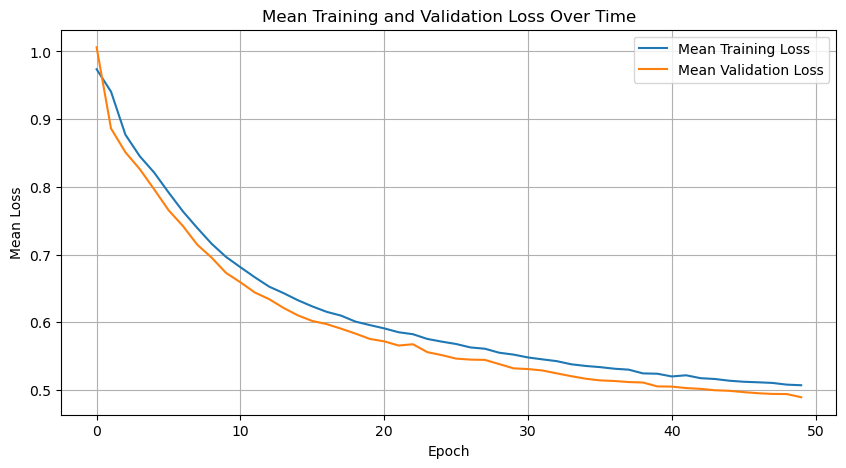

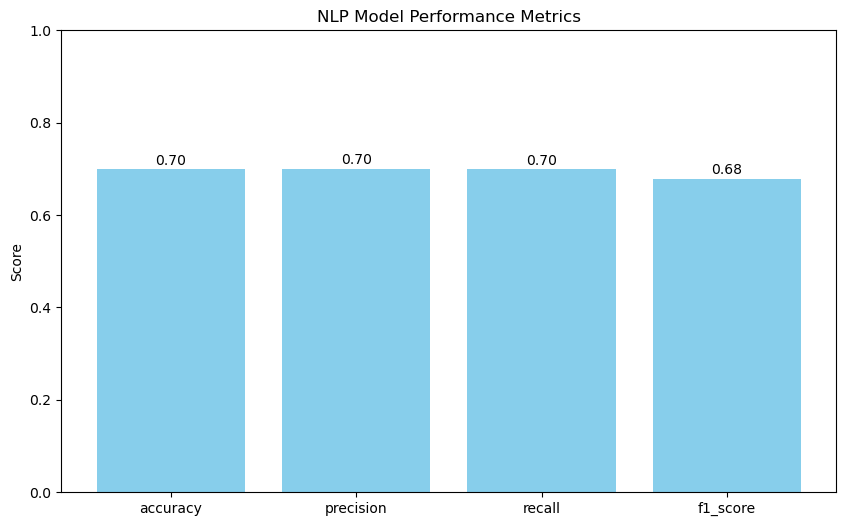

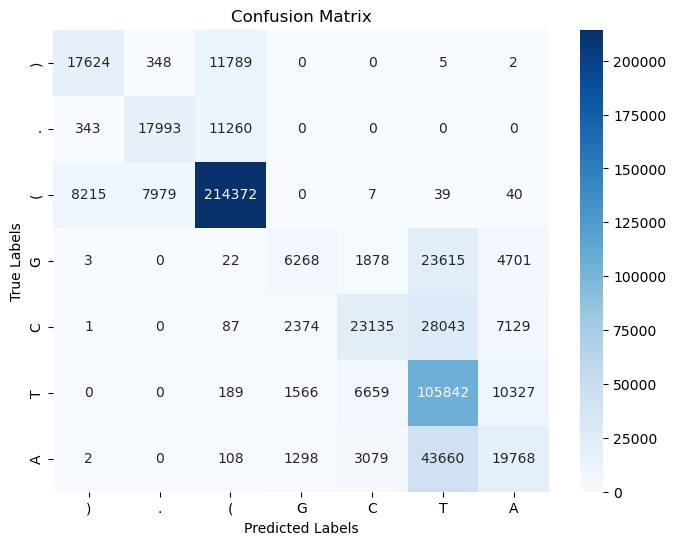

KeyError: 8

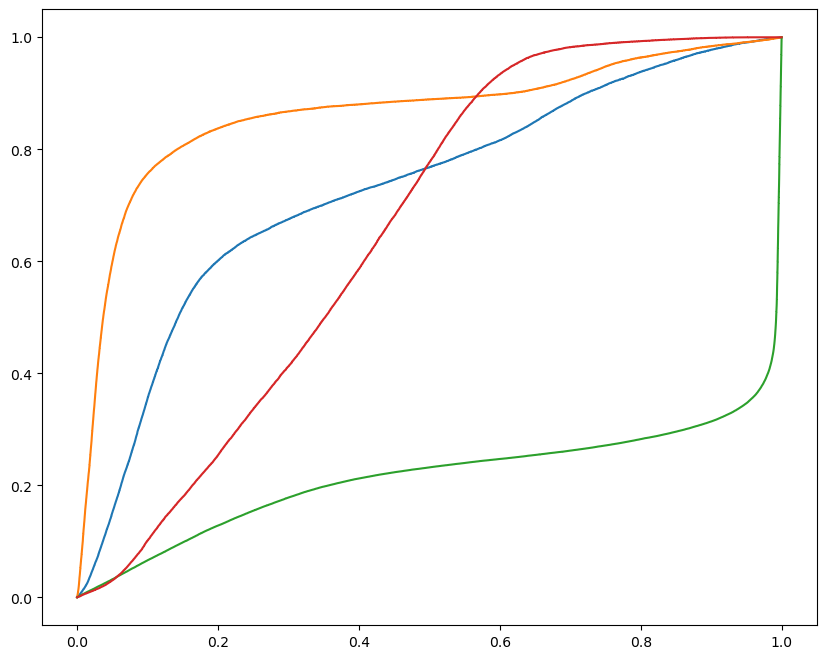

In [64]:
plot_mean_loss(cfg)

plot_metrics(processed_true, processed_preds)
plot_confusion_matrix(processed_true, processed_preds)
plot_roc_auc_from_logits(masked_logits, processed_true)
per_token_metrics(processed_true, processed_preds, tokenizer)


### Seq Struct Regression

Mean Squared Error (MSE): 0.07204971435724657
Root Mean Squared Error (RMSE): 0.2684207785497363
Mean Absolute Error (MAE): 0.22658305670958512
R-squared (Coefficient of Determination): 0.14169701939657497
Mean Absolute Percentage Error (MAPE): 37716476750.7517
Explained Variance Score: 0.1426729846232515


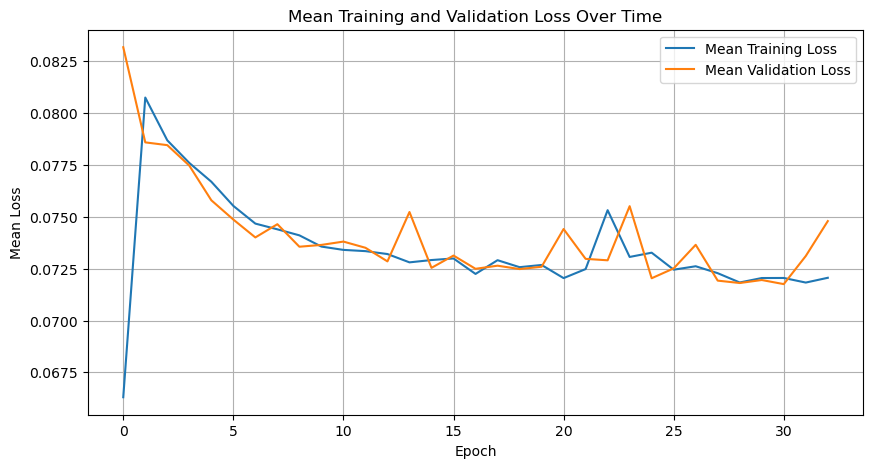

In [6]:
cfg = read_cfg('../aptamer_transformer/config.yaml')

y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')


y_true_flat = np.concatenate(y_true_list)
y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

mse, rmse, mae, r2, mape, explained_variance = evaluate_regression_model(y_true_flat, y_pred_flat)

plot_mean_loss(cfg)

# Masked Language Model Analysis

In [49]:
cfg = read_cfg('config.yaml')


tokenizer = AutoTokenizer.from_pretrained('../data/AptamerBERT_tokenizer')

y_true_list, y_pred_list = load_test_predictions(
    filename=f'{cfg["results_path"]}/test_predictions.pkl')
y_true_flat = np.concatenate(y_true_list)

y_pred_flat_src = []
y_pred_flat_tgt = []

for y_pred in y_pred_list:
    
    y_pred_flat_src.extend(y_pred[0].cpu())
    y_pred_flat_tgt.extend(y_pred[2].cpu())

y_preds = np.array(y_pred_flat_src)
target = np.array(y_pred_flat_tgt)
y_true = np.array(y_true_flat)

# y_true_tokenized = np.array(tokenizer(list(map(lambda x: ' '.join(x), y_true)), padding=True).input_ids)
y_preds_tokenized = np.array(np.argmax(y_preds,axis=2))

processed_preds, processed_true = process_data(y_preds, target)
masked_logits = extract_masked_logits(y_preds, target)

### MLM X Aptamer BERT Flash Attention & Rot_pos_encoding & GELU

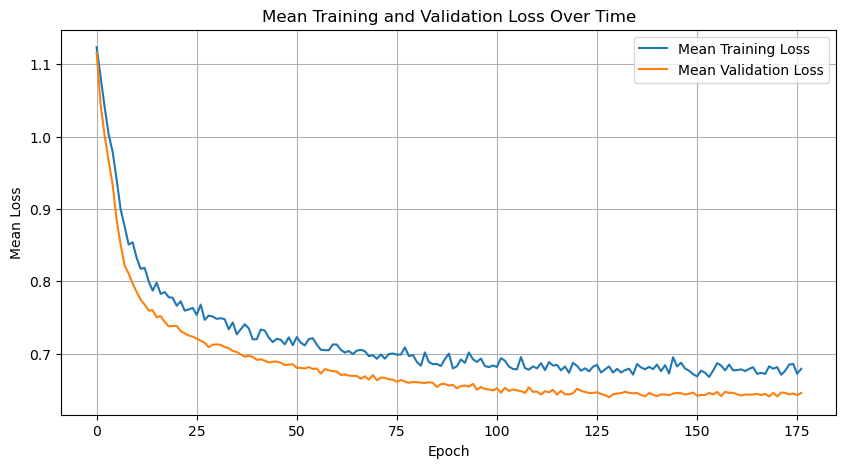

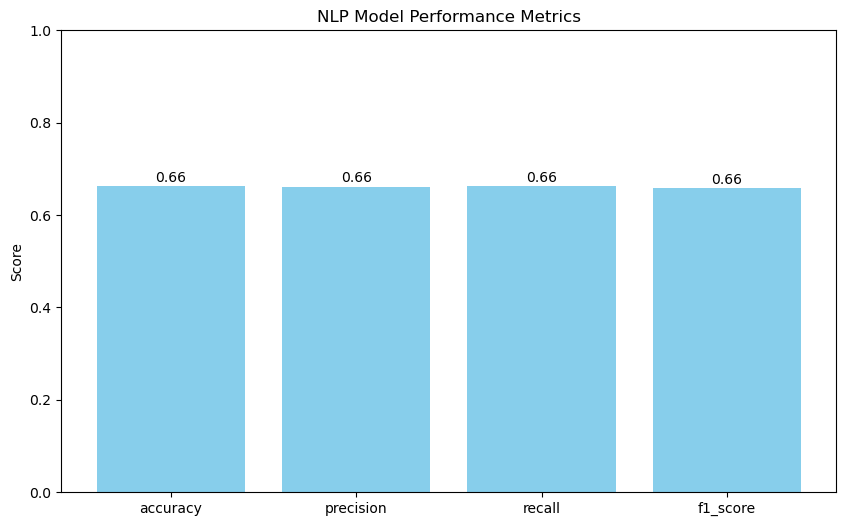

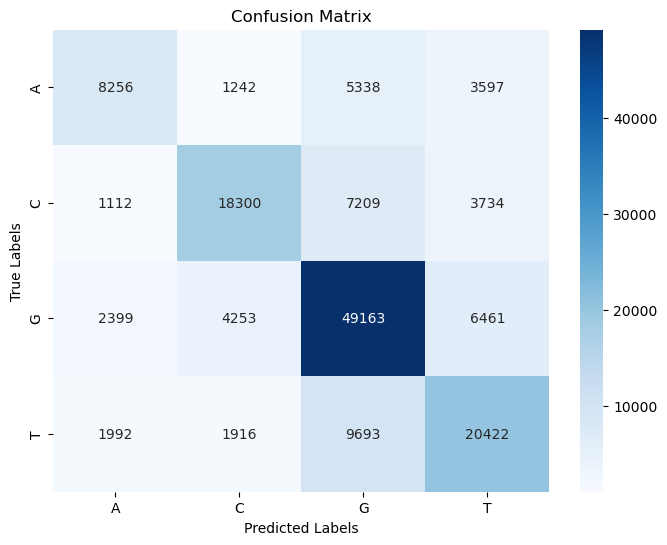

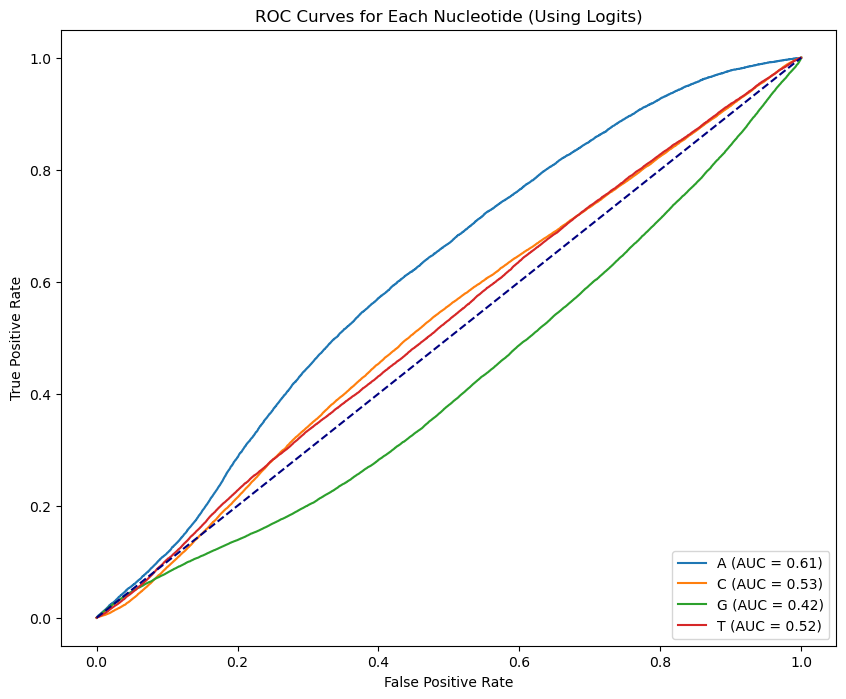


Metrics for nucleotide A:
  Accuracy: 0.4479
  Sensitivity: 0.4479
  Specificity: 0.9566
  MCC: 0.4597

Metrics for nucleotide C:
  Accuracy: 0.6029
  Sensitivity: 0.6029
  Specificity: 0.9354
  MCC: 0.5734

Metrics for nucleotide G:
  Accuracy: 0.7894
  Sensitivity: 0.7894
  Specificity: 0.7314
  MCC: 0.5157

Metrics for nucleotide T:
  Accuracy: 0.6002
  Sensitivity: 0.6002
  Specificity: 0.8758
  MCC: 0.4751


In [50]:
plot_mean_loss(cfg)

plot_metrics(processed_true, processed_preds)
plot_confusion_matrix(processed_true, processed_preds)
plot_roc_auc_from_logits(masked_logits, processed_true)
per_token_metrics(processed_true, processed_preds)


In [65]:
common_error_subsequences_with_pos = find_common_error_subsequences_around_masked(y_true_tokenized, y_preds_tokenized, target, window_size=9)

plot_error_position_distribution(common_error_subsequences_with_pos)

NameError: name 'y_true_tokenized' is not defined

In [ ]:
common_error_subsequences_with_pos

# Classification Analysis

#### Data Analysis

In [42]:
cfg = read_cfg('config.yaml')
dna_dataset = load_dataset(cfg)

Total data: 1287750
Max sequence length: 41


<Axes: >

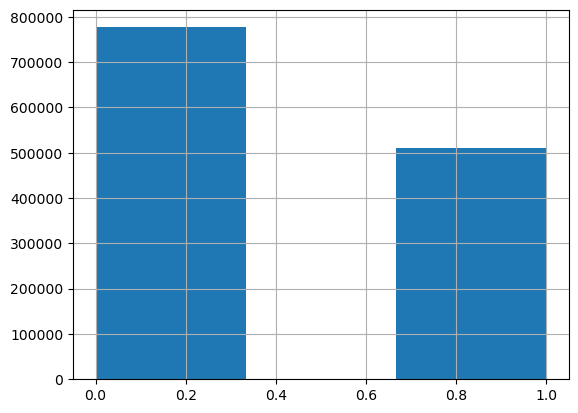

In [61]:
total_data, max_seq_len = dna_dataset.attn_masks.shape
max_seq_len = max_seq_len - 1
seq_len_dist = torch.sum(dna_dataset.attn_masks, axis=1) - 1
enrichment_scores_dist = dna_dataset.y

print(f'Total data: {total_data}')
print(f'Max sequence length: {max_seq_len}')
H, bins = np.histogram([int(cla) for cla in  enrichment_scores_dist.tolist()], bins=2)
enrichment_scores_dist.hist(bins=3)
# plt.bar([0,1],  labels)


#### Transformer Encoder Classification

Accuracy: 0.6668
Precision: 0.5721
Recall: 0.6590
F1-Score: 0.6125
CSI: 0.4414


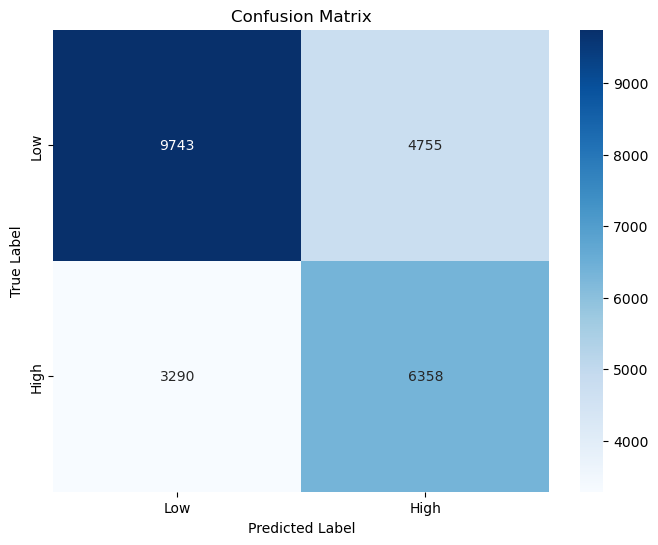

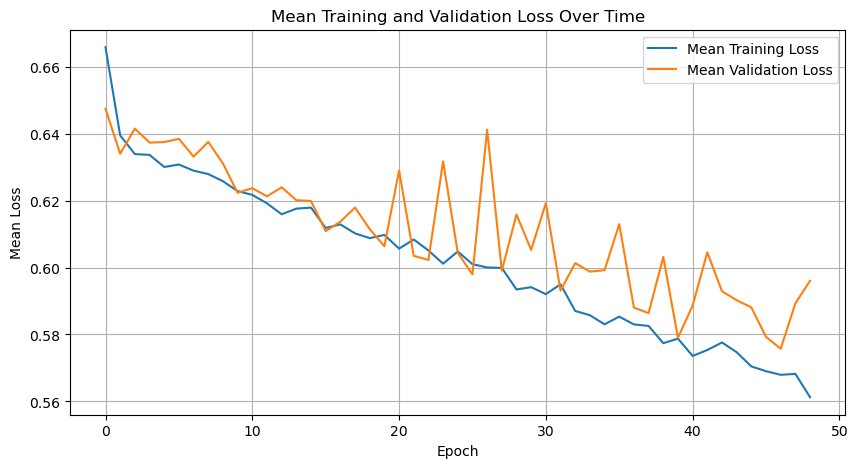

In [74]:
cfg = read_cfg('config.yaml')
y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')


y_true_flat = np.concatenate(y_true_list)

y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

plot_classification_metrics(y_true_flat, y_pred_flat, class_names=['Low', 'High'])

plot_mean_loss(cfg)


#### Aptamer BERT Classification

Accuracy: 0.7163
Precision: 0.6289
Recall: 0.6919
F1-Score: 0.6589
CSI: 0.4913


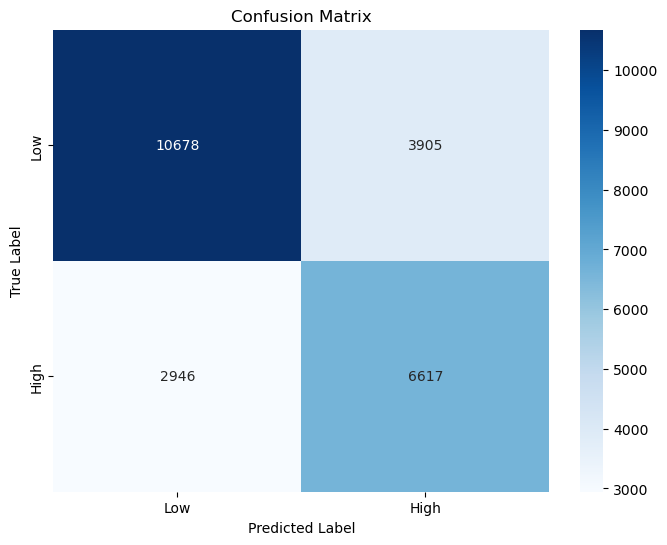

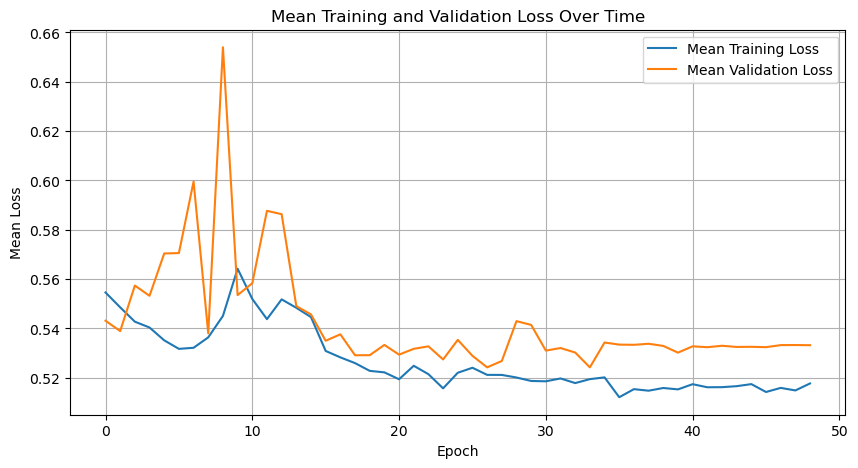

In [75]:
cfg = read_cfg('config.yaml')
y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')


y_true_flat = np.concatenate(y_true_list)

y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

plot_classification_metrics(y_true_flat, y_pred_flat, class_names=['Low', 'High'])

plot_mean_loss(cfg)


#### X Aptamer Bert Classifier

Accuracy: 0.6809
Precision: 0.6654
Recall: 0.3795
F1-Score: 0.4833
CSI: 0.3187


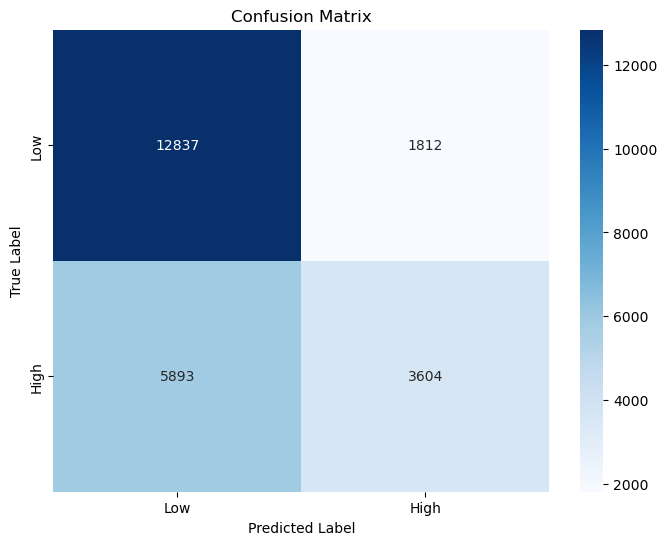

JSONDecodeError: Extra data: line 1 column 1385 (char 1384)

In [76]:
cfg = read_cfg('config.yaml')

plot_mean_loss(cfg)

y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')

y_true_flat = np.concatenate(y_true_list)

y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

plot_classification_metrics(y_true_flat, y_pred_flat, class_names=['Low', 'High'])



# Evidence Analysis

## Test Data

In [2]:
cfg = read_cfg('config.yaml')
y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')
y_true_flat = np.concatenate(y_true_list)
y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

x_list = load_test_input(filename=f'{cfg["results_path"]}/test_input.pkl')


device = torch.device("cuda:0")  
cfg.update({
    'device': device,
})

model = get_model(cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=cfg['learning_rate'])

# Load the checkpoint
checkpoint = torch.load(cfg['checkpoint_path'])  # Replace X with the epoch number

# Restore the model and optimizer states
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Move the model to evaluation mode if you are doing inference
model = model.eval()


In [3]:
tokenized_seqs = [inner[0] for inner in x_list]
attn_mask = [~inner[1].bool() for inner in x_list]


In [4]:
test_preds = []

for seqs, mask in zip(tokenized_seqs, attn_mask):
    seqs, mask = seqs.to(device), mask.to(device)
    with torch.no_grad():
        test_preds.append(model.predict_uncertainty(seqs, attn_mask=mask))
    
prob = np.concatenate([pred[0].cpu().numpy() for pred in test_preds])
u = np.concatenate([pred[1].cpu().numpy() for pred in test_preds])
aleatoric = np.concatenate([pred[2].cpu().numpy() for pred in test_preds])
epistemic = np.concatenate([pred[3].cpu().numpy() for pred in test_preds])

In [71]:
epistemic.shape

NameError: name 'epistemic' is not defined

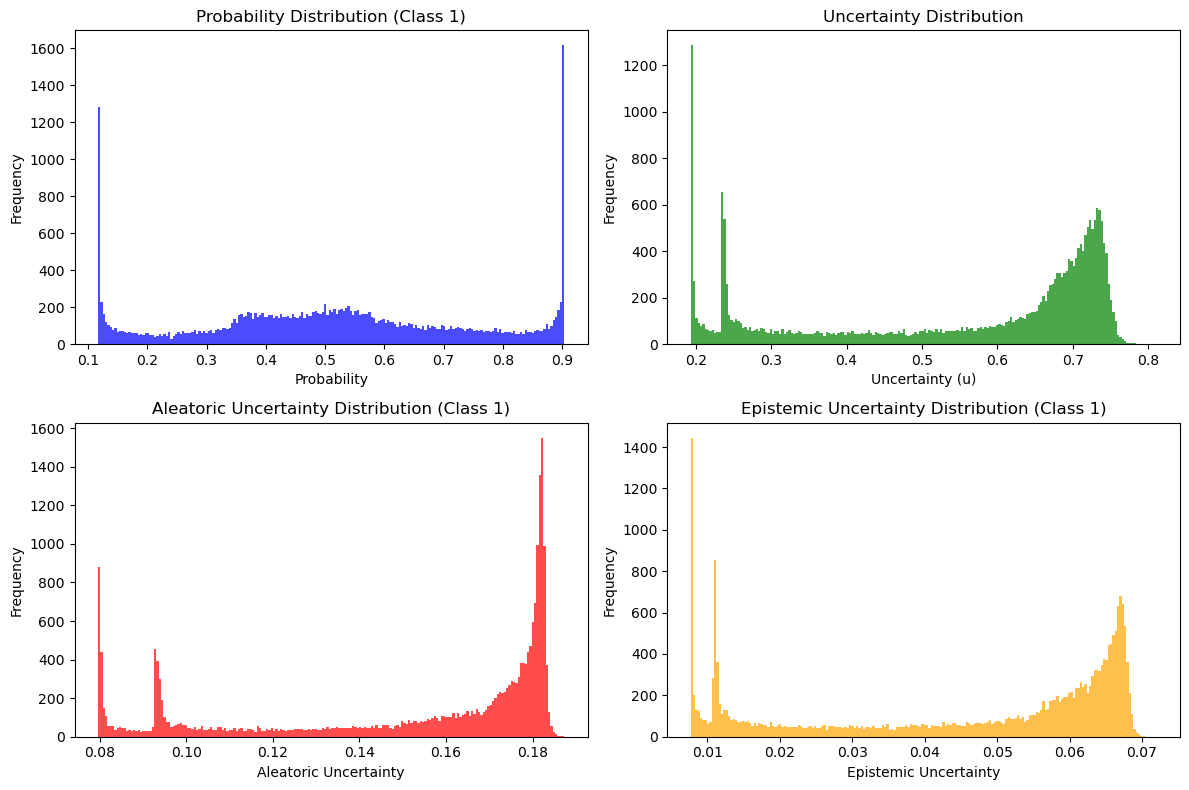

In [9]:
# Assuming the provided data is representative of the full dataset
# Plotting histograms for each metric

plt.figure(figsize=(12, 8))

# Probability histogram for the first class
plt.subplot(2, 2, 1)
plt.hist(prob[:, 0], bins=200, alpha=0.7, color='blue')
plt.title('Probability Distribution (Class 0)')
plt.xlabel('Probability')
plt.ylabel('Frequency')

# Uncertainty (u) histogram
plt.subplot(2, 2, 2)
plt.hist(u[:, 0], bins=200, alpha=0.7, color='green')
plt.title('Uncertainty Distribution')
plt.xlabel('Uncertainty (u)')
plt.ylabel('Frequency')

# Aleatoric uncertainty histogram for the first class
plt.subplot(2, 2, 3)
plt.hist(aleatoric[:, 0], bins=200, alpha=0.7, color='red')
plt.title('Aleatoric Uncertainty Distribution (Class 0)')
plt.xlabel('Aleatoric Uncertainty')
plt.ylabel('Frequency')

# Epistemic uncertainty histogram for the first class
plt.subplot(2, 2, 4)
plt.hist(epistemic[:, 0], bins=200, alpha=0.7, color='orange')
plt.title('Epistemic Uncertainty Distribution (Class 0)')
plt.xlabel('Epistemic Uncertainty')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Accuracy: 0.7017
Precision: 0.5978
Recall: 0.7253
F1-Score: 0.6554


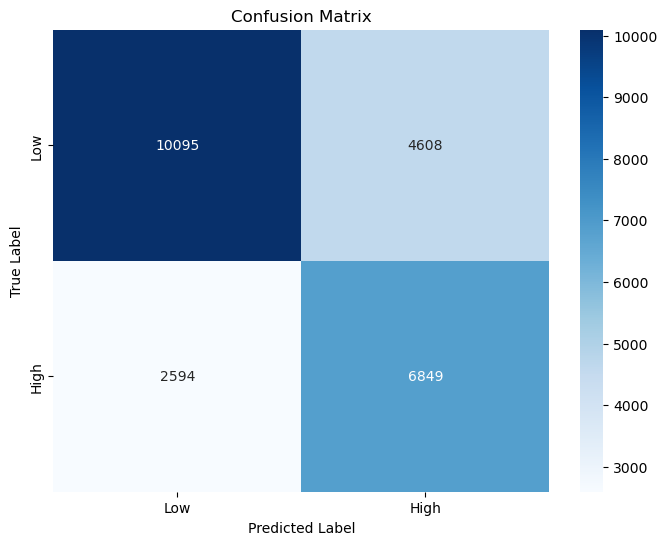

In [6]:
plot_classification_metrics(y_true_flat, y_pred_flat, class_names=['Low', 'High'])

## All Data

In [36]:
dna_dataset = load_dataset(cfg)

In [63]:
all_loader = DataLoader(dna_dataset, batch_size=2048)

In [64]:

all_preds = []

for seqs, mask, y in all_loader:
    seqs = seqs.long().to(device)
    mask = ~mask.bool().to(device)
    with torch.no_grad():
        all_preds.append(model.predict_uncertainty(seqs, attn_mask=mask))
    
prob = np.concatenate([pred[0].cpu().numpy() for pred in all_preds])
u = np.concatenate([pred[1].cpu().numpy() for pred in all_preds])
aleatoric = np.concatenate([pred[2].cpu().numpy() for pred in all_preds])
epistemic = np.concatenate([pred[3].cpu().numpy() for pred in all_preds])

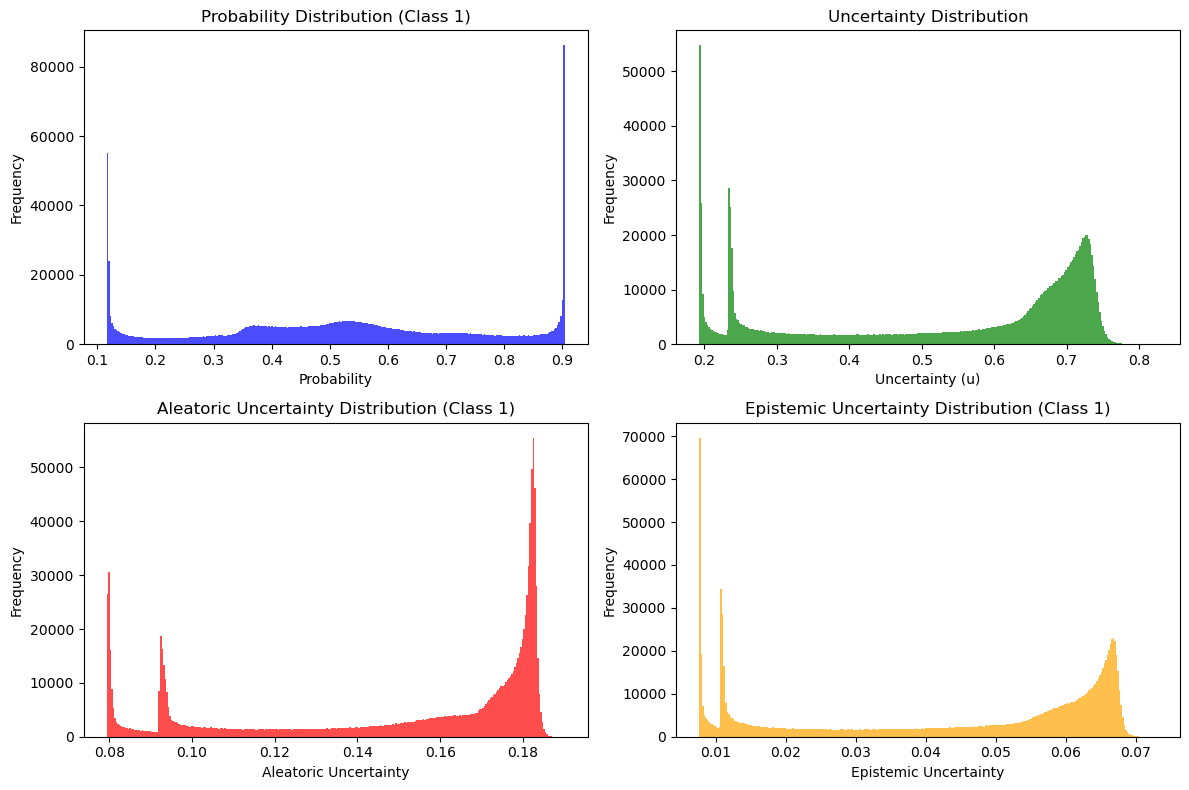

In [65]:
# Assuming the provided data is representative of the full dataset
# Plotting histograms for each metric

plt.figure(figsize=(12, 8))

# Probability histogram for the first class
plt.subplot(2, 2, 1)
plt.hist(prob[:, 0], bins=300, alpha=0.7, color='blue')
plt.title('Probability Distribution (Class 1)')
plt.xlabel('Probability')
plt.ylabel('Frequency')

# Uncertainty (u) histogram
plt.subplot(2, 2, 2)
plt.hist(u[:, 0], bins=300, alpha=0.7, color='green')
plt.title('Uncertainty Distribution')
plt.xlabel('Uncertainty (u)')
plt.ylabel('Frequency')

# Aleatoric uncertainty histogram for the first class
plt.subplot(2, 2, 3)
plt.hist(aleatoric[:, 0], bins=300, alpha=0.7, color='red')
plt.title('Aleatoric Uncertainty Distribution (Class 1)')
plt.xlabel('Aleatoric Uncertainty')
plt.ylabel('Frequency')

# Epistemic uncertainty histogram for the first class
plt.subplot(2, 2, 4)
plt.hist(epistemic[:, 0], bins=300, alpha=0.7, color='orange')
plt.title('Epistemic Uncertainty Distribution (Class 1)')
plt.xlabel('Epistemic Uncertainty')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Regression Analysis

### Data Analysis

In [6]:
cfg = read_cfg('config.yaml')
dna_dataset = load_dataset(cfg)

Total data: 1287750
Max sequence length: 41


Text(0, 0.5, 'Frequency')

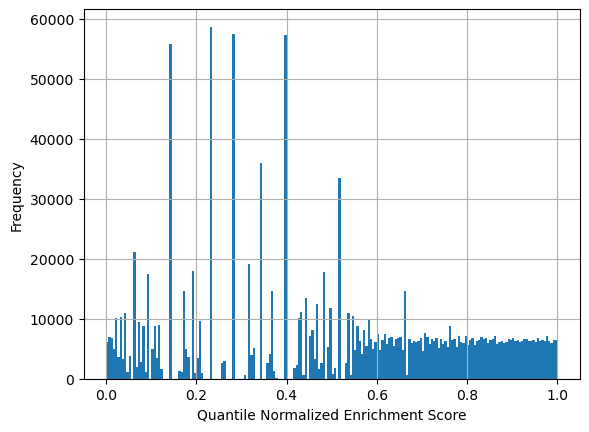

In [28]:
total_data, max_seq_len = dna_dataset.attn_masks.shape
max_seq_len = max_seq_len - 1
seq_len_dist = torch.sum(dna_dataset.attn_masks, axis=1) - 1
enrichment_scores_dist = dna_dataset.y

print(f'Total data: {total_data}')
print(f'Max sequence length: {max_seq_len}')

ax = enrichment_scores_dist.hist(bins=200)
ax.set_xlabel('Quantile Normalized Enrichment Score')
ax.set_ylabel('Frequency')


#### Transformer Encoder Regression

Mean Squared Error (MSE): 0.0641389496463265
Root Mean Squared Error (RMSE): 0.2532566872687205
Mean Absolute Error (MAE): 0.2051516152280832
R-squared (Coefficient of Determination): 0.2253544280902371
Mean Absolute Percentage Error (MAPE): 29.074573867666075
Explained Variance Score: 0.23778548455839765


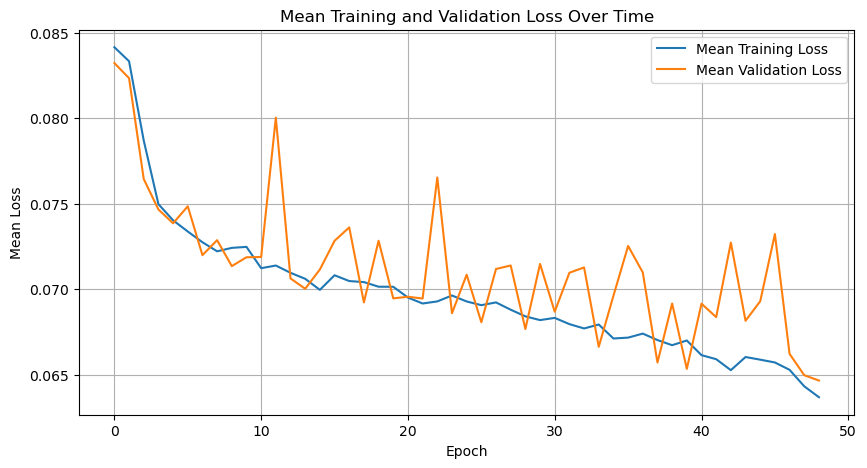

In [38]:
cfg = read_cfg('config.yaml')
y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')


y_true_flat = np.concatenate(y_true_list)
y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

mse, rmse, mae, r2, mape, explained_variance = evaluate_regression_model(y_true_flat, y_pred_flat)

plot_mean_loss(cfg)

#### Aptamer Bert Regression

Mean Squared Error (MSE): 0.05982096267716389
Root Mean Squared Error (RMSE): 0.24458324283802416
Mean Absolute Error (MAE): 0.18763397610142502
R-squared (Coefficient of Determination): 0.28052996225501425
Mean Absolute Percentage Error (MAPE): 146963398314.716
Explained Variance Score: 0.3228510037489257


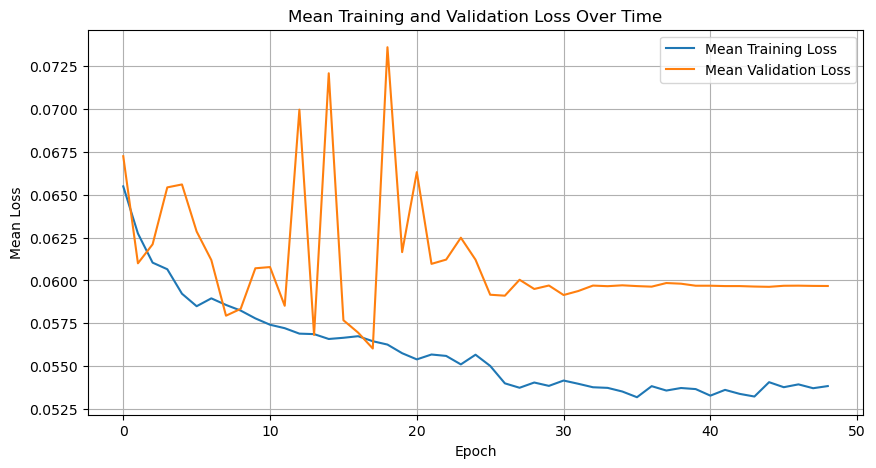

In [37]:
cfg = read_cfg('config.yaml')
y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')


y_true_flat = np.concatenate(y_true_list)
y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

mse, rmse, mae, r2, mape, explained_variance = evaluate_regression_model(y_true_flat, y_pred_flat)

plot_mean_loss(cfg)


#### X Transformer Encoder: Flash Attention Only

Mean Squared Error (MSE): 0.07066502439468147
Root Mean Squared Error (RMSE): 0.26582893821907627
Mean Absolute Error (MAE): 0.22437445442451331
R-squared (Coefficient of Determination): 0.1548477408205594
Mean Absolute Percentage Error (MAPE): 53546236518.49766
Explained Variance Score: 0.15490687889868393


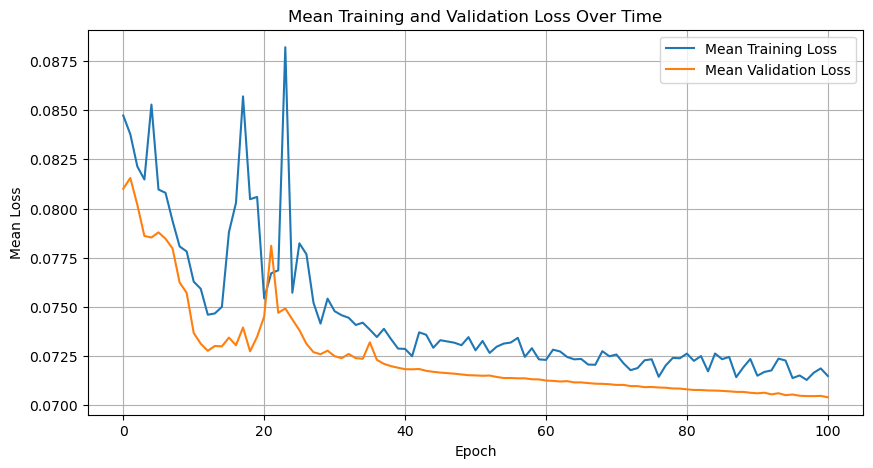

In [32]:
cfg = read_cfg('config.yaml')
y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')


y_true_flat = np.concatenate(y_true_list)
y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

mse, rmse, mae, r2, mape, explained_variance = evaluate_regression_model(y_true_flat, y_pred_flat)

plot_mean_loss(cfg)


#### X Transformer Encoder: Flash Attention & Rot_pos_encoding & GELU

Mean Squared Error (MSE): 0.05780383738869848
Root Mean Squared Error (RMSE): 0.24042428618735354
Mean Absolute Error (MAE): 0.19064411145939486
R-squared (Coefficient of Determination): 0.30628093689833225
Mean Absolute Percentage Error (MAPE): 2.8901119697552677
Explained Variance Score: 0.3097624760745812


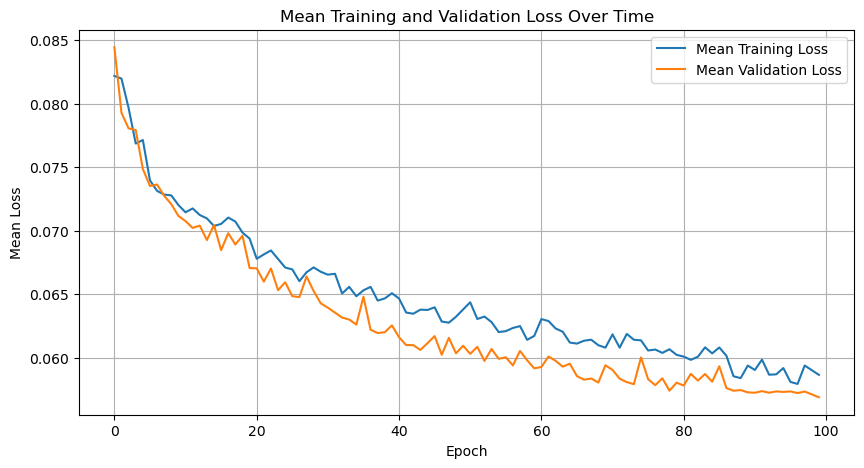

In [37]:
cfg = read_cfg('config.yaml')
y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')


y_true_flat = np.concatenate(y_true_list)
y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

mse, rmse, mae, r2, mape, explained_variance = evaluate_regression_model(y_true_flat, y_pred_flat)

plot_mean_loss(cfg)


#### X Aptamer Bert Regression

Mean Squared Error (MSE): 0.05788969944814557
Root Mean Squared Error (RMSE): 0.24060278354197312
Mean Absolute Error (MAE): 0.1883356513701626
R-squared (Coefficient of Determination): 0.3033276662340444
Mean Absolute Percentage Error (MAPE): 32.19012657549618
Explained Variance Score: 0.3151967494708119


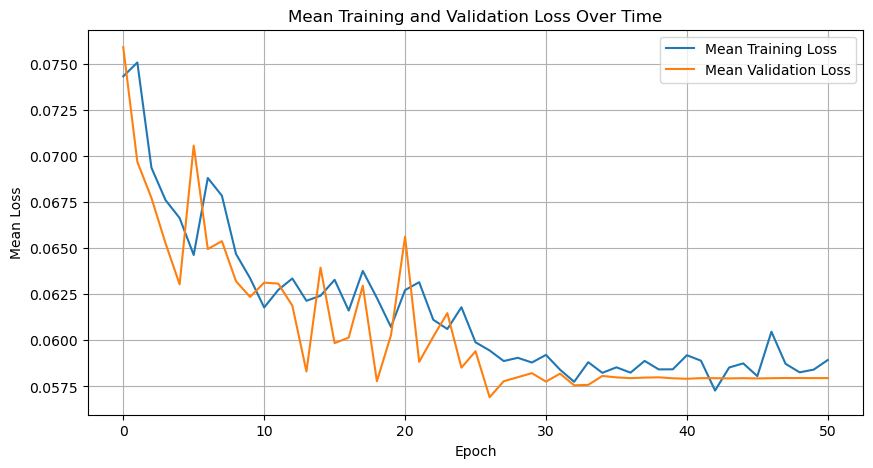

In [53]:
cfg = read_cfg('config.yaml')
y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')


y_true_flat = np.concatenate(y_true_list)
y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

mse, rmse, mae, r2, mape, explained_variance = evaluate_regression_model(y_true_flat, y_pred_flat)

plot_mean_loss(cfg)
